# ARS on Pendulum (runnable notebook)

This notebook implements **Augmented Random Search (ARS)** for **Gymnasium's `Pendulum-v1`**.

**What you’ll do:**
1. Install dependencies  
2. Implement ARS (linear policy + state normalization)  
3. Train on Pendulum and view learning curves


In [1]:
# If you're running this on Colab or a fresh environment, uncomment:
# !pip -q install gymnasium numpy matplotlib

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

## ARS implementation

- Policy: **linear** `a = W @ s_norm`  
- Update rule: try random perturbations `+/- nu * delta`, keep top-`b`, move `W` toward directions that improved reward.


In [2]:
class RunningNorm:
    """Online mean/var for state normalization (per-dimension)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.eps = eps
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2 = np.zeros(dim, dtype=np.float64)  # sum of squares of diffs from mean

    def update(self, x):
        x = np.asarray(x, dtype=np.float64)
        self.count += 1
        delta = x - self.mean
        self.mean += delta / self.count
        delta2 = x - self.mean
        self.M2 += delta * delta2

    @property
    def var(self):
        if self.count < 2:
            return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x):
        x = np.asarray(x, dtype=np.float64)
        return (x - self.mean) / self.std


def rollout(env, W, rn: RunningNorm, seed=None, max_steps=200):
    """Run one episode and return total reward."""
    obs, _ = env.reset(seed=seed)
    total = 0.0
    for _ in range(max_steps):
        rn.update(obs)
        x = rn.normalize(obs)

        # Linear deterministic policy
        a = float(W @ x)  # scalar action for Pendulum
        a = np.clip(a, env.action_space.low[0], env.action_space.high[0])

        obs, reward, terminated, truncated, _ = env.step(np.array([a], dtype=np.float32))
        total += float(reward)
        if terminated or truncated:
            break
    return total


def eval_policy(env, W, rn, seed, episodes=5, max_steps=200):
    scores = []
    for k in range(episodes):
        scores.append(rollout(env, W, rn, seed=seed + 10_000 + k, max_steps=max_steps))
    return float(np.mean(scores))


def train_ars(
    seed=0,
    iters=200,
    N=16,          # number of random directions
    b=8,           # keep top-b directions
    alpha=0.02,    # step size
    nu=0.03,       # perturbation scale
    max_steps=200,
    eval_every=10,
    eval_episodes=5
):
    rng = np.random.default_rng(seed)
    env = gym.make("Pendulum-v1")

    obs_dim = env.observation_space.shape[0]  # 3
    W = np.zeros(obs_dim, dtype=np.float64)   # linear weights
    rn = RunningNorm(obs_dim)

    history = {
        "iter": [],
        "eval_return": [],
    }

    # initial eval
    init_eval = eval_policy(env, W, rn, seed=seed, episodes=eval_episodes, max_steps=max_steps)
    history["iter"].append(0)
    history["eval_return"].append(init_eval)

    for t in range(1, iters + 1):
        deltas = rng.standard_normal(size=(N, obs_dim))
        r_pos = np.zeros(N, dtype=np.float64)
        r_neg = np.zeros(N, dtype=np.float64)

        # Evaluate +/- perturbations (2N rollouts)
        for k in range(N):
            r_pos[k] = rollout(env, W + nu * deltas[k], rn, seed=seed + t * 10_000 + 2 * k, max_steps=max_steps)
            r_neg[k] = rollout(env, W - nu * deltas[k], rn, seed=seed + t * 10_000 + 2 * k + 1, max_steps=max_steps)

        # Rank directions by best of the two returns; keep top b
        scores = np.maximum(r_pos, r_neg)
        top_idx = np.argsort(scores)[-b:]

        # Normalize step size by reward std over the selected directions (2b rewards)
        rewards_used = np.concatenate([r_pos[top_idx], r_neg[top_idx]])
        sigma_R = np.std(rewards_used)
        if sigma_R < 1e-8:
            sigma_R = 1.0

        # Compute update
        step = np.zeros_like(W)
        for k in top_idx:
            step += (r_pos[k] - r_neg[k]) * deltas[k]

        W = W + (alpha / (b * sigma_R)) * step

        # periodic evaluation
        if (t % eval_every == 0) or (t == 1):
            e = eval_policy(env, W, rn, seed=seed + 999_000 + t, episodes=eval_episodes, max_steps=max_steps)
            history["iter"].append(t)
            history["eval_return"].append(e)

    env.close()
    return W, history

## Train ARS (multi-seed)

Notes:
- Pendulum returns are **negative**; “better” means **less negative**.
- We run multiple fixed seeds and report aggregate statistics across seeds.
- If learning is slow, increase `iters`, `N`, and `b` a bit.


In [3]:
# Hyperparameters (good starting point)
base_config = dict(
    iters=200,
    N=16,
    b=8,
    alpha=0.02,
    nu=0.03,
    max_steps=200,
    eval_every=10,
    eval_episodes=5,
)

# Use fixed, recorded seeds for fair/reproducible comparison.
seed_list = [0, 1, 2, 3, 4]

runs = []
for seed in seed_list:
    W_i, hist_i = train_ars(seed=seed, **base_config)
    final_i = hist_i["eval_return"][-1]
    runs.append({"seed": seed, "W": W_i, "hist": hist_i, "final": final_i})
    print(f"seed={seed} final eval return: {final_i:.2f}")

final_returns = np.array([r["final"] for r in runs], dtype=np.float64)
print("\nAcross seeds")
print(f"final return mean +- std: {final_returns.mean():.2f} +- {final_returns.std():.2f}")
print(f"best: {final_returns.max():.2f}, worst: {final_returns.min():.2f}")

# Keep a representative run in W, hist for optional rendering/inspection.
best_idx = int(np.argmax(final_returns))
best_run = runs[best_idx]
W = best_run["W"]
hist = best_run["hist"]
print(f"Using best-seed run for W/hist: seed={best_run['seed']}")

seed=0 final eval return: -1035.82
seed=1 final eval return: -1246.38
seed=2 final eval return: -1023.94
seed=3 final eval return: -1383.62
seed=4 final eval return: -1428.46

Across seeds
final return mean +- std: -1223.64 +- 169.25
best: -1023.94, worst: -1428.46
Using best-seed run for W/hist: seed=2


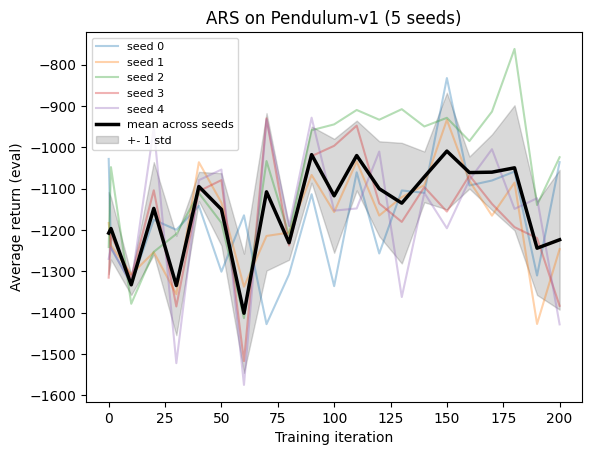

In [4]:
# Plot learning curves across seeds + mean/std
x = np.array(runs[0]["hist"]["iter"], dtype=np.float64)
Y = np.array([r["hist"]["eval_return"] for r in runs], dtype=np.float64)

plt.figure()
for i, r in enumerate(runs):
    plt.plot(x, Y[i], alpha=0.35, linewidth=1.5, label=f"seed {r['seed']}")

mean_curve = Y.mean(axis=0)
std_curve = Y.std(axis=0)
plt.plot(x, mean_curve, color="black", linewidth=2.5, label="mean across seeds")
plt.fill_between(x, mean_curve - std_curve, mean_curve + std_curve, color="black", alpha=0.15, label="+- 1 std")

plt.xlabel("Training iteration")
plt.ylabel("Average return (eval)")
plt.title(f"ARS on Pendulum-v1 ({len(seed_list)} seeds)")
plt.legend(loc="best", fontsize=8)
plt.show()

## (Optional) Watch a trained policy

If you have a local setup that supports rendering, you can record a short rollout.
On some hosted notebook environments, rendering may not work.


In [5]:
# Optional: render one episode (may not work in all notebook environments)
try:
    env = gym.make("Pendulum-v1", render_mode="rgb_array")
    rn = RunningNorm(env.observation_space.shape[0])
    total = rollout(env, W, rn, seed=123, max_steps=200)
    print("One-episode return:", total)
    env.close()
except Exception as e:
    print("Render-mode episode failed (this is normal on some platforms):", e)

One-episode return: -942.9900664458731
